In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import multivariate_normal

# Gaussianas 1D

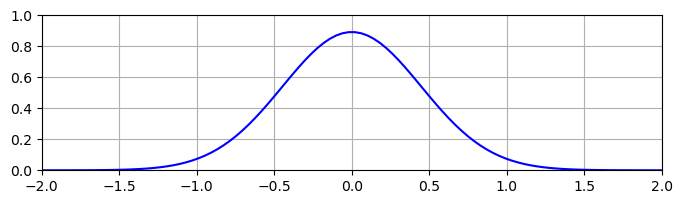

In [2]:
def Gaussian(x, mu, sigma2):
    coefficient = 1.0/np.sqrt(sigma2*2*np.pi)
    exponetial = np.exp(-(x - mu)**2/(2*sigma2))
    return coefficient*exponetial

x = np.linspace(-2,2,100)

mu = 0
sigma2 = .2
y = Gaussian(x, mu, sigma2)

fig = plt.figure(figsize=(8,5), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

ax.plot(x, y, 'b-')

ax.axis([-2,2,0,1])
ax.grid()

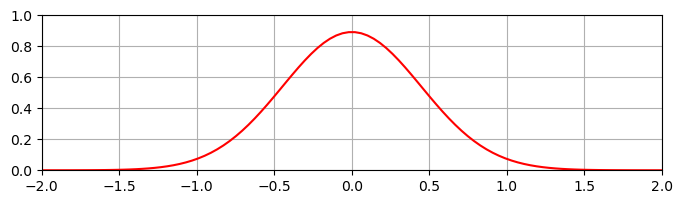

In [3]:
fig = plt.figure(figsize=(8,5), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

std = np.sqrt(sigma2)

# Mesma função no Numpy, entretanto considera STD
y = norm.pdf(x, mu, std)
ax.plot(x, y, 'r-')

ax.axis([-2,2,0,1])
ax.grid()

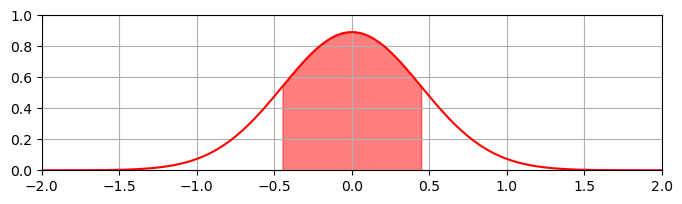

In [4]:
fig = plt.figure(figsize=(8,5), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

ax.plot(x, y, 'r-')

# 1 std: 0.6827
# 2 std: 0.9545
# 3 std: 0.9973
pt1 = mu + 1*std
pt2 = mu - 1*std

ptx = np.linspace(pt1, pt2, 20)
pty = norm.pdf(ptx, mu, std)

ax.fill_between(ptx, pty, color='r', alpha=.5)

ax.axis([-2,2,0,1])
ax.grid()

# Gaussianas 2D

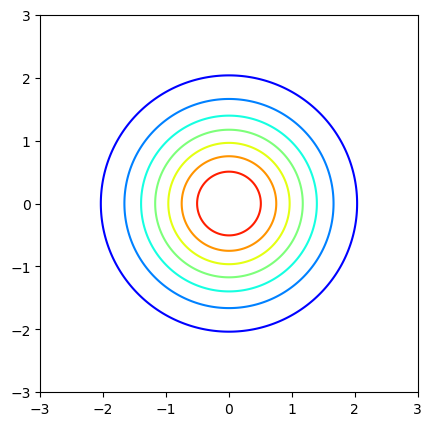

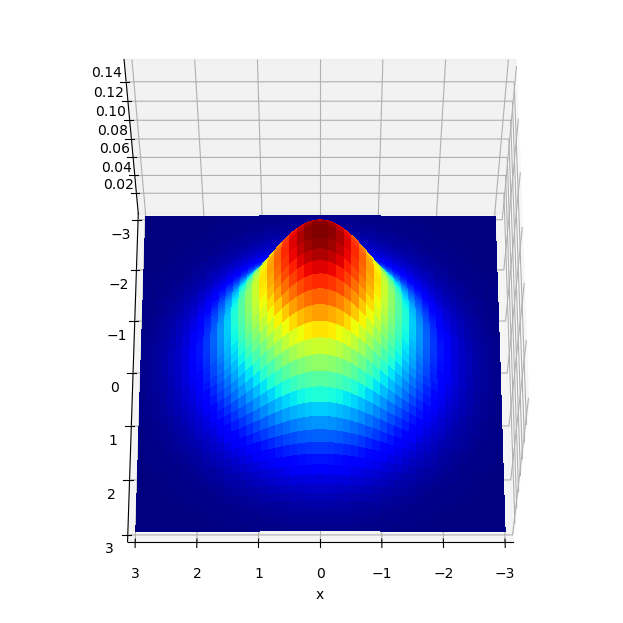

In [5]:
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))
mv_norm = multivariate_normal([0, 0], [[1.0, 0], [0, 1.0]])

# Contour
fig = plt.figure(figsize=(8,5), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

ax.contour(x, y, mv_norm.pdf(pos), cmap='jet')
ax.axis([-3,3,-3,3])


# Surface
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, mv_norm.pdf(pos), cmap='jet', linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.axis([-3,3,-3,3])
ax.view_init(elev=60, azim=90)

# Multiplicação de Gaussianas

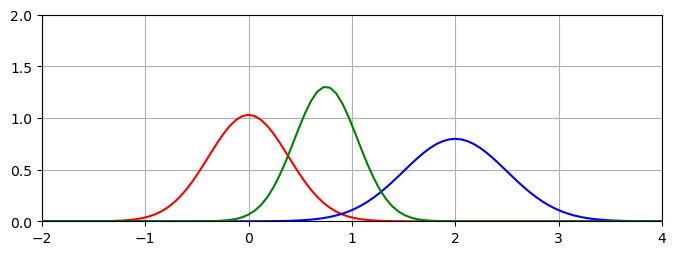

In [6]:
# https://ccrma.stanford.edu/~jos/sasp/Product_Two_Gaussian_PDFs.html

x = np.linspace(-2,4,100)

mu1 = 0
sigma21 = .15
y1 = norm.pdf(x, mu1, np.sqrt(sigma21))

mu2 = 2
sigma22 = .25
y2 = norm.pdf(x, mu2, np.sqrt(sigma22))

fig = plt.figure(figsize=(8,5), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

ax.plot(x, y1, 'r-')
ax.plot(x, y2, 'b-')

ax.axis([-2,4,0,2])
ax.grid()

mu_hat = (mu1*sigma22+mu2*sigma21)/(sigma22+sigma21)
sigma2_hat = 1/(1/sigma21+1/sigma22)
y_hat = norm.pdf(x, mu_hat, np.sqrt(sigma2_hat))

ax.plot(x, y_hat, 'g-')

# Filtro de Kalman

(0.0, 4.0, 0.0, 3.0478487217335757)

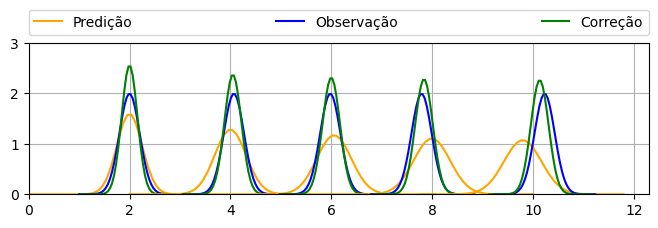

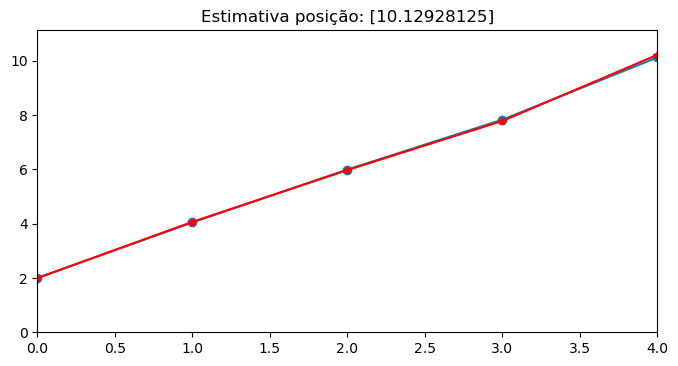

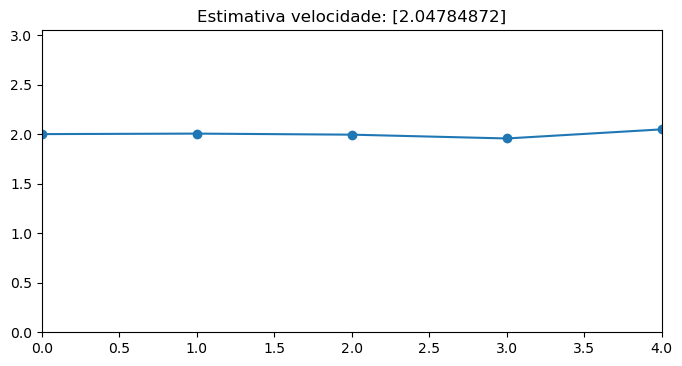

In [7]:
def predicao(mu, S, A, B, u, R):
    mu_pred = A @ mu + B @ u
    S_pred = A @ S @ A.T + R
    return mu_pred, S_pred

def correcao(mu_pred, S_pred, C, Q, z):    
    K = S_pred @ C.T @ np.linalg.inv(C @ S_pred @ C.T + Q)    
    mu_new = mu_pred + K @ (z - C @ mu_pred)
    S_new = S_pred - K @ C @ S_pred
    return mu_new, S_new

# Parâmetros constantes
dt = 1
Tmax = 5

# Processo / Predição
A = np.array([[1, dt], [0, 1]])
B = np.array([[dt**2/2], [dt]])

sigma_d = 0.25                                   # Desvio padrão de d [m]
sigma_v = 0.10                                   # Desvio padrão de v [m/s]
R = np.array([[sigma_d**2, 0], [0, sigma_v**2]]) # Covariância do Processo


# Observação / Correção
C = np.array([[1, 0]])

sigma_l = 0.2                    # Desvio padrão de l [m]
Q = np.array([[sigma_l**2]])     # Covariância da Observação


# Inicialização
v = 2
mu = np.array([[0], [v]])        # Estado: Posição, Velocidade
S = np.array([[0, 0], [0, 0]])   # Covariância do Estado

u = np.array([[0]])              # Vamos considerar velocidade constante (a = 0)

fig = plt.figure(figsize=(8,6), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

hist_mu = []
hist_z = []

# Tempo de simulação (steps)
t = 1
while t <= Tmax:
    
    # Predição
    mu_pred, S_pred = predicao(mu, S, A, B, u, R)
    
    #Correção
    z = np.random.normal(v*t, sigma_l)
    mu, S = correcao(mu_pred, S_pred, C, Q, z)

    # Plots das Gaussianas
    x = np.linspace(mu_pred[0]-2, mu_pred[0]+2, 50)
    y = norm.pdf(x, mu_pred[0], np.sqrt(S_pred[0,0]))
    line_pred = ax.plot(x, y, '-', color='orange')
    
    x = np.linspace(z-1, z+1, 50)
    y = norm.pdf(x, z, np.sqrt(Q[0]))
    ax.plot(x, y, 'b-')    

    x = np.linspace(mu[0]-1, mu[0]+1, 50)
    y = norm.pdf(x, mu[0], np.sqrt(S[0,0]))
    ax.plot(x, y, 'g-')

    t += dt
    hist_mu.append(mu)
    hist_z.append(z)
    

ax.axis([0, (Tmax*mu[1])+mu[1], 0, 3])
ax.grid()
ax.legend(['Predição', 'Observação', 'Correção'], bbox_to_anchor=(0, 1.02, 1, 0.2), mode="expand", borderaxespad=0, ncol=3)



fig = plt.figure(figsize=(8,4), dpi=100)
ax = fig.add_subplot(111)

hist_z = np.array(hist_z)
hist_mu = np.array(hist_mu)
ax.plot(hist_mu[:,0], 'o-')
ax.plot(hist_z, 'r*-')
ax.set_title(f'Estimativa posição: {hist_mu[-1,0]}')
ax.axis([0, Tmax-1, 0, mu[0]+1])




fig = plt.figure(figsize=(8,4), dpi=100)
ax = fig.add_subplot(111)

hist_mu = np.array(hist_mu)
ax.plot(hist_mu[:,1], 'o-')
ax.set_title(f'Estimativa velocidade: {hist_mu[-1,1]}')
ax.axis([0, Tmax-1, 0, mu[1]+1])

# Para praticar

- Variar a entrada de controle do exemplo e verificar o comportamento.
- Estender o exemplo para considerar um robô com 3 DoF (x, y, $\theta$).
- Plotar a elipse de confiança a partir da matriz de covariância.
    - https://cookierobotics.com/007/
- Fazer a fusão de múltiplos sensores com diferentes níveis de confiança.